In [5]:
from scipy.io import loadmat
from scipy.interpolate import griddata
import numpy as np
from numpy import matlib
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import animation
import xarray as xr
import verde as vd
import cmocean
plt.rcParams['animation.html'] = 'jshtml'

import model
import importlib
importlib.reload(model)
from model import *

In [8]:
xmin = 2.37e6
xmax = 2.57e6
ymin = -0.47e6
ymax = -0.35e6

region = [xmin, xmax, ymin, ymax]

ds = xr.open_dataset('../denman_example/raw_data/bedmachine/BedMachineAntarctica-v3.nc')

ds = ds.sel(x=slice(region[0], region[1]), y=slice(region[3], region[2]))
ds

<xarray.Dataset> Size: 2MB
Dimensions:    (x: 401, y: 241)
Coordinates:
  * x          (x) int32 2kB 2370000 2370500 2371000 ... 2569000 2569500 2570000
  * y          (y) int32 964B -350000 -350500 -351000 ... -469500 -470000
Data variables:
    mapping    |S1 1B ...
    mask       (y, x) int8 97kB ...
    firn       (y, x) float32 387kB ...
    surface    (y, x) float32 387kB ...
    thickness  (y, x) float32 387kB ...
    bed        (y, x) float32 387kB ...
    errbed     (y, x) float32 387kB ...
    source     (y, x) int8 97kB ...
    dataid     (y, x) int8 97kB ...
    geoid      (y, x) int16 193kB ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [26]:
p1 = (2460e3, -425e3)
p2 = (2476e3, -395e3)

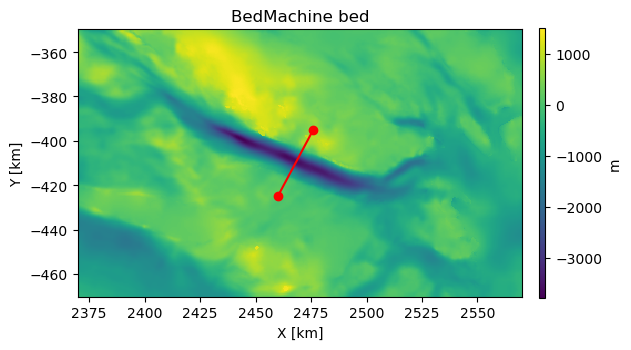

In [27]:
plt.figure(figsize=(7,3.5))
plt.pcolormesh(ds.x/1000, ds.y/1000, ds.bed)
plt.plot(np.array([p1[0], p2[0]])/1000, np.array([p1[1], p2[1]])/1000, 'o-', c='r')
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('BedMachine bed')
plt.colorbar(pad=0.03, aspect=40, label='m')
plt.show()

In [28]:
n_points = 1000
coords_profile, dists = vd.profile_coordinates(p1, p2, size=n_points)
xx, yy = np.meshgrid(ds.x.values, ds.y.values)

coordinates = np.array([xx.flatten(), yy.flatten()]).T
pred_coords = np.array(coords_profile).T

dist_msk = vd.distance_mask(coords_profile, 12e3, (xx.flatten(), yy.flatten()))
coordinates = coordinates[dist_msk,:]

bed_profile = griddata(coordinates, ds.bed.values.flatten()[dist_msk], pred_coords)
surf_profile = griddata(coordinates, ds.surface.values.flatten()[dist_msk], pred_coords)
thick_profile = griddata(coordinates, ds.thickness.values.flatten()[dist_msk], pred_coords)

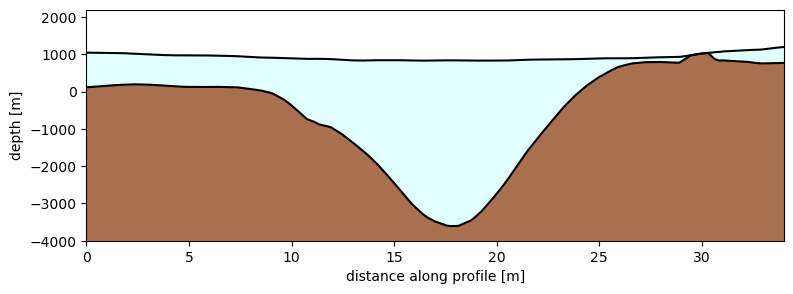

In [77]:
water_color = '#21a0cb'
ice_color = 'lightcyan'
rock_color = '#a9704f'

distskm = dists/1000

fig, ax = plt.subplots(1, 1, figsize=(9,3))

ax.fill_between(distskm, surf_profile-thick_profile, surf_profile, color=ice_color, rasterized=True)
ax.fill_between(distskm, np.full(dists.size, -4000), bed_profile, color=rock_color, rasterized=True)
ax.plot(distskm, surf_profile, c='k')
ax.plot(distskm, surf_profile-thick_profile, c='k')
ax.set_xlim(0, np.max(dists)/1000)
ax.set_ylim(-4000, np.max(surf_profile)+1000)
ax.set_xlabel('distance along profile [m]')
ax.set_ylabel('depth [m]')
plt.show()

In [86]:
dists.size

1000

In [115]:
x = dists
z = np.arange(2000, -4000, -20)

xx, zz = np.meshgrid(x, z)

ep = np.zeros_like(xx)
sig = np.zeros_like(xx)
mu = np.ones_like(xx)

ep.shape, sig.shape, mu.shape, x.size, z.size

((300, 1000), (300, 1000), (300, 1000), 1000, 300)

In [116]:
for j in range(x.size):
    ep[:,j] = np.where(z < bed_profile[j], 20, 3.16)
    ep[:,j] = np.where(z > surf_profile[j], 1, ep[:,j])

    sig[:,j] = np.where(z < bed_profile[j], 1/1000, 0.01/1000)
    sig[:,j] = np.where(z > surf_profile[j], 0, sig[:,j])

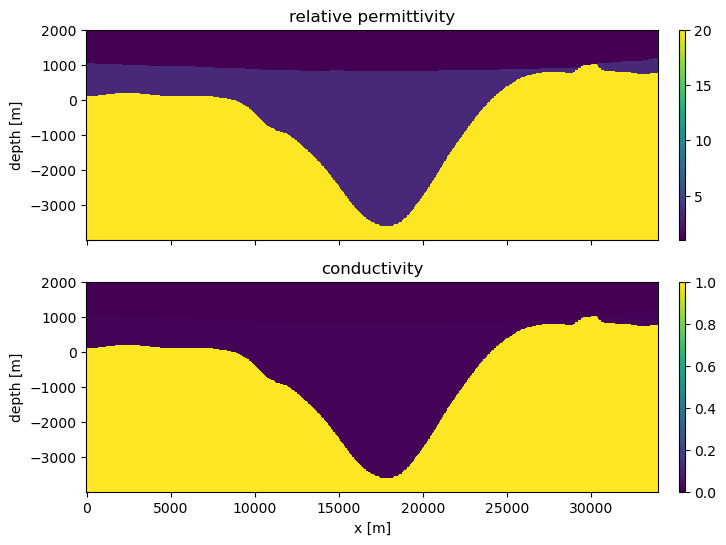

In [117]:
fig, axs = plt.subplots(2, 1, figsize=(9,6), sharex=True)

ax = axs[0]
im = ax.pcolormesh(x, z, ep)
ax.set_ylabel('depth [m]')
ax.set_title('relative permittivity')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)

ax = axs[1]
im = ax.pcolormesh(x, z, sig*1000)
ax.set_ylabel('depth [m]')
ax.set_xlabel('x [m]')
ax.set_title('conductivity')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40)
plt.show()

In [118]:
epmin = np.min(ep)
epmax = np.max(ep)
mumin = np.min(mu)
mumax = np.max(mu)

epmin, epmax, mumin, mumax

(np.float64(1.0), np.float64(20.0), np.float64(1.0), np.float64(1.0))

In [120]:
center_freq = 150e6

t = np.arange(0, 100e-9, 1e-10)
srcpulse = blackharrispulse(center_freq, t)

# Use finddx.m to determine maximum possible spatial field discretization
dx, wlmin, fmax = finddx(epmax, mumax, srcpulse, t, 0.02)
print(f"Maximum frequency contained in source pulse = {fmax / 1e6} MHz")
print(f"Minimum wavelength in simulation grid = {wlmin} m")
print(f"Maximum possible electric/magnetic field discretization (dx,dz) = {dx} m")
print(f"Maximum possible electrical property discretization (dx/2,dz/2) = {dx / 2} m")

Maximum frequency contained in source pulse = 419.921875 MHz
Minimum wavelength in simulation grid = 0.15963834111764302 m
Maximum possible electric/magnetic field discretization (dx,dz) = 0.031927668223528605 m
Maximum possible electrical property discretization (dx/2,dz/2) = 0.015963834111764302 m


In [121]:
# Set dx and dz here (m) using the above results as a guide
dx = 0.03
dz = 0.03
print(f"Using dx = {dx} m, dz = {dz} m")

Using dx = 0.03 m, dz = 0.03 m


In [122]:
# Find the maximum possible time step using this dx and dz
dtmax = finddt(epmin, mumin, dx, dz)
print(f"Maximum possible time step with this discretization = {dtmax / 1e-9} ns")

Maximum possible time step with this discretization = 0.06065111151548384 ns


In [123]:
# Set proper dt here (s) using the above results as a guide
dt = 6e-11
print(f"Using dt = {dt / 1e-9:.02f} ns")

Using dt = 0.06 ns


In [124]:
# Create time vector (s) and corresponding source pulse
t = np.arange(0,250e-9, dt)
srcpulse = blackharrispulse(center_freq, t)

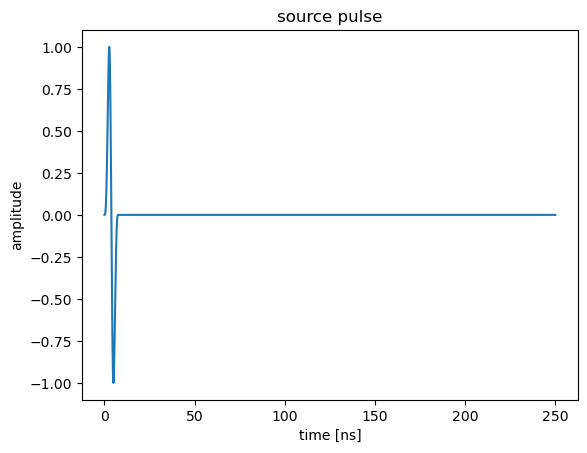

In [125]:
plt.subplots()
plt.plot(t*1e9,srcpulse)
plt.ylabel('amplitude')
plt.xlabel('time [ns]')
plt.title('source pulse')
plt.savefig('figures/srcpulse.png', dpi=300, bbox_inches='tight')
plt.show()

In [126]:
ep.shape, x.shape, z.shape

((300, 1000), (1000,), (300,))

In [127]:
# Interpolate electrical property grids to proper spatial discretization
x2 = np.arange(min(x), max(x)-dx/2, dx / 2)
z2 = np.arange(min(z), max(z)-dx/2, dz / 2)
ep2 = gridinterp(ep, x, z, x2, z2, 'nearest')
mu2 = gridinterp(mu, x, z, x2, z2, 'nearest')
sig2 = gridinterp(sig, x, z, x2, z2, 'nearest')

MemoryError: Unable to allocate 6.57 TiB for an array with shape (2266666, 398666) and data type float64

In [17]:
np.count_nonzero(np.isnan(ep2))

0

In [18]:
x2.shape, z2.shape, ep2.shape

((999,), (549,), (999, 549))

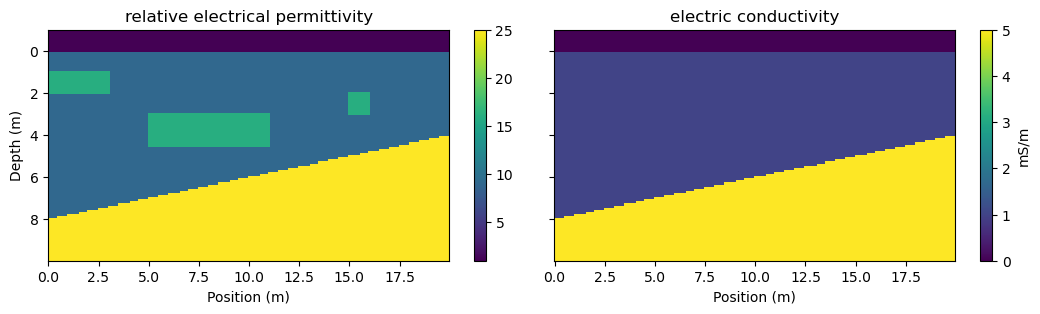

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(13,3), sharey=True, gridspec_kw=dict(wspace=0.01))
ax = axs[0]
im = ax.pcolormesh(x2, z2, ep2.T)
ax.invert_yaxis()
ax.set_title("relative electrical permittivity")
ax.set_xlabel('Position (m)')
ax.set_ylabel('Depth (m)')
plt.colorbar(im, ax=ax)

ax = axs[1]
im = ax.pcolormesh(x2, z2, sig2.T*1000)
ax.set_title("electric conductivity")
ax.set_xlabel('Position (m)')
plt.colorbar(im, ax=ax, label='mS/m')
plt.savefig('figures/earth_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Pad electrical property matrices for PML absorbing boundaries
npml = 10
ep3, x3, z3 = padgrid(ep2, x2, z2, 2*npml+1)
mu3, _, _ = padgrid(mu2, x2, z2, 2*npml+1)
sig3, _, _ = padgrid(sig2, x2, z2, 2*npml+1)

ep3.shape, mu3.shape, sig3.shape

((1041, 591), (1041, 591), (1041, 591))

In [26]:
x3.size, x2.size

(1041, 999)